# Object Detection with YOLO

# Objective

In this challenge, we apply the Data Science Lifecycle to build an object detection model using YOLO. The goal is to detect two object classes of our choice.

#  Part 1: Data Collection & Labeling

# Dataset

To build this dataset, I collected 100 images of mugs and 100 images of bottles from Google Images. These images were uploaded to Roboflow, where I annotated them using bounding boxes.
The dataset meets the following requirements:

- A balanced number of images for 2 classes: 100 images per class (mugs and bottles)

- Bounding box annotations for all images

- Exported from Roboflow in YOLO format.

- Split: 70% training, 20% validation, 10% testing

- Later augmented (in this notebook) to increase dataset size and improve generalization


## Link to the Roboflow project:

[Mug vs Bottle Computer Vision Project](https://universe.roboflow.com/marie-therese-younan-gaqrt/mug-vs-bottle)

**Public Dataset Link:**  
[Roboflow Dataset - Mug vs Bottle](https://universe.roboflow.com/marie-therese-younan-gaqrt/mug-vs-bottle)


#  Part 2: Object Detection with YOLO

#  Data Exploration

## Uploading the Dataset to Colab


In [ ]:
#First, upload the .zip folder or file
from google.colab import files
uploaded = files.upload()

Saving Mug vs Bottle.v1i.yolov5pytorch.zip to Mug vs Bottle.v1i.yolov5pytorch.zip


In [ ]:
#Unzip the file
import zipfile
import os

zip_filename = "Mug vs Bottle.v1i.yolov5pytorch.zip"

#Unzip the dataset
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall("dataset")

#Check structure
os.listdir("dataset")


['train', 'valid', 'README.roboflow.txt', 'test', 'data.yaml']

##Dataset Visualization

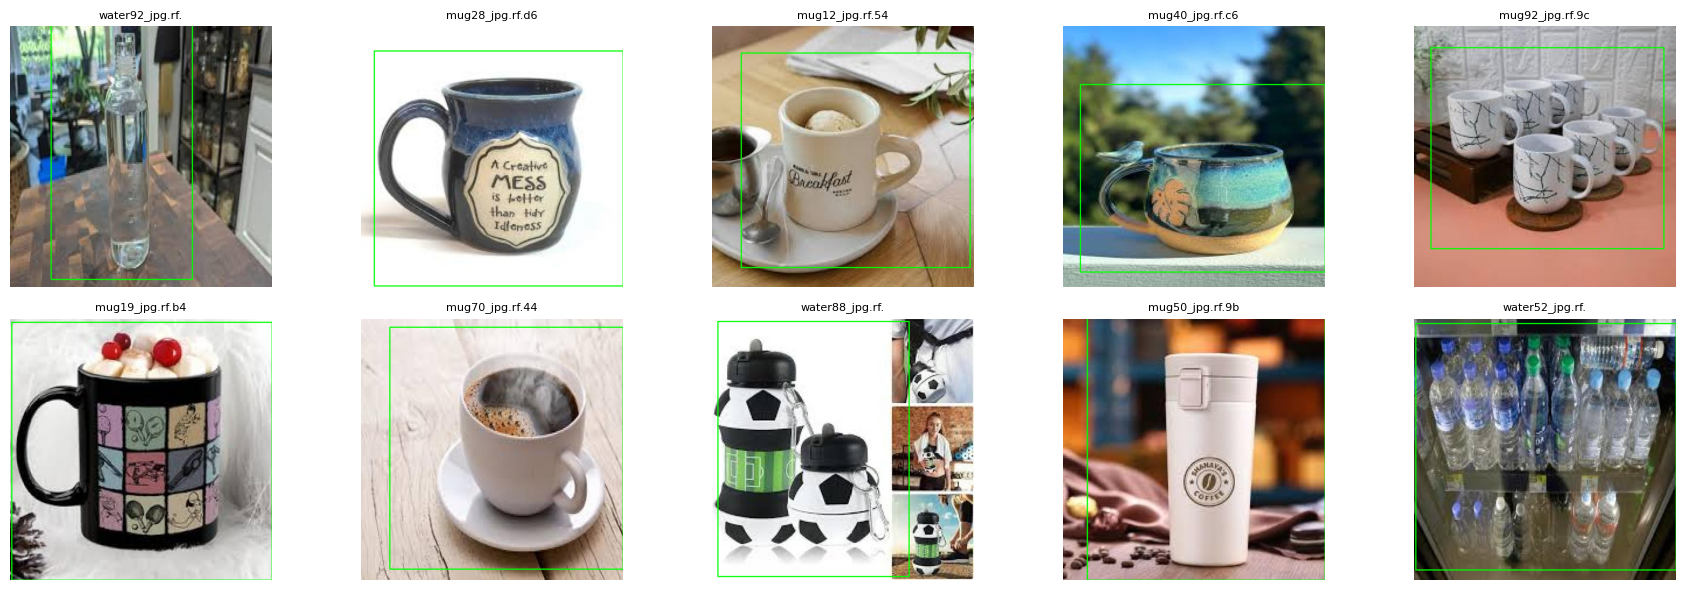

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import random

image_dir = "dataset/train/images"
label_dir = "dataset/train/labels"
#Let's print 10 random images of our dataset
image_files = random.sample(os.listdir(image_dir), 10)

rows, cols = 2, 5
plt.figure(figsize=(18, 6))

for i, img_file in enumerate(image_files):
    img_path = os.path.join(image_dir, img_file)
    label_path = os.path.join(label_dir, img_file.replace(".jpg", ".txt").replace(".png", ".txt"))

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape

    #Only read labels if the file exists
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f:
                cls, x, y, bw, bh = map(float, line.strip().split())
                x1 = int((x - bw / 2) * w)
                y1 = int((y - bh / 2) * h)
                x2 = int((x + bw / 2) * w)
                y2 = int((y + bh / 2) * h)
                cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.title(img_file[:15], fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()


# Model Building

## Dataset Augmentation (200 - 500 Images)


I currently have 200 images (100 for each class Mug or Bottle), and the goal is to generate more synthetic variations to improve model generalization.



In [ ]:
#Install Albumentations
!pip install albumentations --quiet

In [ ]:
#Define Augmentations and Apply to the Data
import os
import cv2
import albumentations as A
import shutil

#Input paths
image_dir = "dataset/train/images"
label_dir = "dataset/train/labels"

#Output paths
aug_image_dir = "dataset/train/images_aug"
aug_label_dir = "dataset/train/labels_aug"

os.makedirs(aug_image_dir, exist_ok=True)
os.makedirs(aug_label_dir, exist_ok=True)

In [ ]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.Rotate(limit=15, p=0.3),
    A.GaussianBlur(p=0.2),
],
bbox_params=A.BboxParams(
    format='yolo',
    label_fields=['class_labels'],
    min_visibility=0.3,
    check_each_transform=False
))

In [ ]:
#Clip bboxes to [0.0, 1.0]
def clip_bbox(bbox):
    return [min(max(coord, 0.0), 1.0) for coord in bbox]

In [ ]:
#Loop through all images
image_files = os.listdir(image_dir)
image_count = 0

for img_file in image_files:
    img_path = os.path.join(image_dir, img_file)
    label_path = os.path.join(label_dir, img_file.replace(".jpg", ".txt").replace(".png", ".txt"))

    #Load image
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w, _ = image.shape

    bboxes = []
    class_labels = []

    #Load and sanitize bounding boxes
    with open(label_path, 'r') as f:
        for line in f.readlines():
            parts = line.strip().split()
            cls = int(float(parts[0]))  #
            bbox = [min(max(float(x), 0.0), 1.0) for x in parts[1:]]
            bboxes.append(bbox)
            class_labels.append(cls)

    #Apply 2 augmentations per image
    for i in range(2):
        augmented = transform(image=image, bboxes=bboxes, class_labels=class_labels)
        aug_img = cv2.cvtColor(augmented["image"], cv2.COLOR_RGB2BGR)
        aug_bboxes = [clip_bbox(bbox) for bbox in augmented["bboxes"]]  #Clip after augmenting
        aug_labels = augmented["class_labels"]

        #Save augmented image
        new_img_name = f"aug_{image_count}_{img_file}"
        cv2.imwrite(os.path.join(aug_image_dir, new_img_name), aug_img)

        #Save corresponding YOLO label
        with open(os.path.join(aug_label_dir, new_img_name.replace(".jpg", ".txt")), "w") as f:
            for bbox, cls in zip(aug_bboxes, aug_labels):
                f.write(f"{cls} {' '.join([str(round(x, 6)) for x in bbox])}\n")

        image_count += 1


In [ ]:
#Merge Augmented Images Back Into our Train Folder
for f in os.listdir(aug_image_dir):
    shutil.move(os.path.join(aug_image_dir, f), os.path.join(image_dir, f))

for f in os.listdir(aug_label_dir):
    shutil.move(os.path.join(aug_label_dir, f), os.path.join(label_dir, f))

#Cleanup
os.rmdir(aug_image_dir)
os.rmdir(aug_label_dir)


In [ ]:
#Check number of training images and labels after augmentation
img_count = len(os.listdir("dataset/train/images"))
label_count = len(os.listdir("dataset/train/labels"))
print(f"Images: {img_count}, Labels: {label_count}")

Images: 420, Labels: 420


### Training and Testing with YOLOv8s


In [ ]:
#Install the Ultralytics YOLOv8 Library
!pip install ultralytics --quiet

In [ ]:
#Import the Library
from ultralytics import YOLO

In [ ]:
import os

for root, dirs, files in os.walk("/content"):
    if "data.yaml" in files:
        print("Found data.yaml at:", os.path.join(root, "data.yaml"))


Found data.yaml at: /content/dataset/data.yaml


In [ ]:
#Train the YOLOv8 Model
#Load a pretrained model
model = YOLO("yolov8n.pt")

#Train the model
results = model.train(
    data="dataset/data.yaml",
    epochs=30,
    imgsz=416,        #I reduced this from 640 to 416 because the session was always crashing
    batch=8,          #similarly here, I reduced the batch size
    name="mug_bottle_yolo_model",
    workers=2,
    device=0
)


100%|██████████| 6.25M/6.25M [00:00<00:00, 125MB/s]

Ultralytics 8.3.167 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)


engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=mug_bottle_yolo_model2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=False, project=None, rect=False, resume=False, retina_masks=False,

100%|██████████| 5.35M/5.35M [00:00<00:00, 93.8MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1511.0±649.9 MB/s, size: 68.5 KB)


train: Scanning /content/dataset/train/labels... 420 images, 0 backgrounds, 0 corrupt: 100%|██████████| 420/420 [00:00<00:00, 2068.98it/s]

train: New cache created: /content/dataset/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 830.9±422.5 MB/s, size: 45.9 KB)


val: Scanning /content/dataset/valid/labels... 40 images, 0 backgrounds, 0 corrupt: 100%|██████████| 40/40 [00:00<00:00, 1966.64it/s]

val: New cache created: /content/dataset/valid/labels.cache


Plotting labels to runs/detect/mug_bottle_yolo_model2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 2 dataloader workers
Logging results to runs/detect/mug_bottle_yolo_model2
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30     0.488G      1.177      2.472      1.537         14        416: 100%|██████████| 53/53 [00:07<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]

                   all         40         40      0.371      0.371      0.396      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30     0.594G      1.178      1.788      1.508         12        416: 100%|██████████| 53/53 [00:07<00:00,  7.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.59it/s]

                   all         40         40      0.433      0.444      0.393      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30     0.613G      1.198      1.688      1.482         13        416: 100%|██████████| 53/53 [00:07<00:00,  7.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.73it/s]

                   all         40         40      0.513      0.462      0.454      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30     0.631G      1.171       1.55      1.462         12        416: 100%|██████████| 53/53 [00:05<00:00,  9.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.68it/s]

                   all         40         40      0.378      0.604      0.438      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30     0.645G      1.151      1.474      1.443         13        416: 100%|██████████| 53/53 [00:06<00:00,  7.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.07it/s]


                   all         40         40      0.823      0.625      0.733      0.359

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30     0.666G      1.174      1.417      1.457         11        416: 100%|██████████| 53/53 [00:05<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.56it/s]

                   all         40         40      0.685      0.776      0.781       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30     0.682G      1.098      1.334      1.393         14        416: 100%|██████████| 53/53 [00:06<00:00,  7.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.42it/s]

                   all         40         40      0.589      0.752      0.696      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30     0.699G      1.077      1.313      1.389         10        416: 100%|██████████| 53/53 [00:05<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.60it/s]

                   all         40         40      0.567      0.525      0.535      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30     0.717G      1.105      1.361      1.418          9        416: 100%|██████████| 53/53 [00:06<00:00,  8.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.56it/s]

                   all         40         40      0.714      0.797      0.767      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30     0.732G      1.058      1.274      1.394         13        416: 100%|██████████| 53/53 [00:06<00:00,  7.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.92it/s]

                   all         40         40      0.829      0.847      0.837      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      0.75G      1.033      1.223      1.356         13        416: 100%|██████████| 53/53 [00:06<00:00,  8.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.54it/s]

                   all         40         40      0.782      0.778       0.85      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30     0.768G     0.9803      1.136      1.312          7        416: 100%|██████████| 53/53 [00:05<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.89it/s]

                   all         40         40      0.739      0.797      0.796      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30     0.781G     0.9801      1.128      1.332         13        416: 100%|██████████| 53/53 [00:06<00:00,  8.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.17it/s]

                   all         40         40       0.78      0.713      0.753      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30     0.801G      0.994      1.155      1.327         11        416: 100%|██████████| 53/53 [00:05<00:00,  9.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.76it/s]

                   all         40         40      0.798      0.857      0.859      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30     0.818G     0.9362       1.07      1.305          8        416: 100%|██████████| 53/53 [00:05<00:00,  9.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.99it/s]

                   all         40         40      0.728      0.828      0.879      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30     0.836G     0.8996      1.012      1.261         11        416: 100%|██████████| 53/53 [00:06<00:00,  8.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.80it/s]

                   all         40         40      0.774      0.837      0.865      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30     0.852G     0.9086     0.9858       1.26         11        416: 100%|██████████| 53/53 [00:05<00:00, 10.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.08it/s]

                   all         40         40       0.88      0.826       0.89      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30     0.869G     0.9354     0.9822      1.287         11        416: 100%|██████████| 53/53 [00:06<00:00,  7.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.68it/s]

                   all         40         40      0.866      0.857      0.923      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30     0.887G      0.906     0.9881      1.278         14        416: 100%|██████████| 53/53 [00:05<00:00,  9.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.77it/s]

                   all         40         40      0.878      0.905      0.932      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30     0.904G     0.8136      0.905      1.228          9        416: 100%|██████████| 53/53 [00:06<00:00,  7.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.84it/s]

                   all         40         40      0.868      0.815      0.921      0.619


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30     0.916G     0.7216     0.9671       1.26          4        416: 100%|██████████| 53/53 [00:05<00:00,  8.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.45it/s]

                   all         40         40      0.875       0.89      0.921       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30     0.938G     0.6841     0.7778      1.246          4        416: 100%|██████████| 53/53 [00:06<00:00,  7.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.66it/s]

                   all         40         40      0.829        0.9      0.861      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30     0.953G     0.6578     0.6943      1.208          4        416: 100%|██████████| 53/53 [00:05<00:00, 10.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.50it/s]

                   all         40         40      0.908      0.789      0.899      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30     0.971G     0.6239      0.673      1.208          4        416: 100%|██████████| 53/53 [00:06<00:00,  7.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.30it/s]

                   all         40         40      0.792        0.9      0.882      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30     0.988G     0.6382     0.6231      1.181          4        416: 100%|██████████| 53/53 [00:05<00:00,  9.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.17it/s]

                   all         40         40      0.929      0.809      0.887      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      1.01G     0.5941     0.5939      1.181          4        416: 100%|██████████| 53/53 [00:06<00:00,  7.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.69it/s]

                   all         40         40      0.889      0.847      0.902      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      1.02G     0.5549     0.5486      1.117          4        416: 100%|██████████| 53/53 [00:05<00:00, 10.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.59it/s]

                   all         40         40      0.887      0.874      0.892      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      1.04G      0.525     0.5174      1.125          4        416: 100%|██████████| 53/53 [00:06<00:00,  7.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.24it/s]

                   all         40         40      0.888      0.872      0.924      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      1.05G     0.5132     0.4953      1.109          4        416: 100%|██████████| 53/53 [00:05<00:00, 10.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.93it/s]

                   all         40         40      0.874       0.92      0.906      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      1.07G     0.4568     0.4701      1.075          4        416: 100%|██████████| 53/53 [00:06<00:00,  8.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.74it/s]

                   all         40         40      0.899      0.918      0.911      0.671



30 epochs completed in 0.057 hours.
Optimizer stripped from runs/detect/mug_bottle_yolo_model2/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/mug_bottle_yolo_model2/weights/best.pt, 6.2MB

Validating runs/detect/mug_bottle_yolo_model2/weights/best.pt...
Ultralytics 8.3.167 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.61it/s]


                   all         40         40      0.899      0.918       0.91      0.671
                bottle         19         19      0.846      0.895      0.868      0.655
                   mug         21         21      0.952      0.941      0.953      0.688
Speed: 0.3ms preprocess, 3.3ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs/detect/mug_bottle_yolo_model2


In [ ]:
#Model Evaluation
from ultralytics import YOLO

#Load the trained model
model = YOLO("runs/detect/mug_bottle_yolo_model2/weights/best.pt")

#Run validation
metrics = model.val()

#Print the evaluation metrics
print("\n=== Model Evaluation Metrics ===")
print(f"Precision (mean): {metrics.box.mp:.3f}")
print(f"Recall (mean): {metrics.box.mr:.3f}")
print(f"mAP@0.5: {metrics.box.map50:.3f}")
print(f"mAP@0.5:0.95: {metrics.box.map:.3f}")


Ultralytics 8.3.167 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 476.9±280.4 MB/s, size: 31.9 KB)


val: Scanning /content/dataset/valid/labels.cache... 40 images, 0 backgrounds, 0 corrupt: 100%|██████████| 40/40 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.71it/s]


                   all         40         40      0.899      0.918      0.909       0.67
                bottle         19         19      0.846      0.895      0.865      0.653
                   mug         21         21      0.952      0.941      0.953      0.688
Speed: 10.0ms preprocess, 15.2ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs/detect/val

=== Model Evaluation Metrics ===
Precision (mean): 0.899
Recall (mean): 0.918
mAP@0.5: 0.909
mAP@0.5:0.95: 0.670


After training for 30 epochs, the YOLOv8s model achieved an mAP50 of 90.9% and an mAP50-95 of 67% on the validation set.

The model shows strong detection capabilities, especially for mugs (mAP50 = 95.3%).

Bottles were also well detected (mAP50 = 86.5%) but had slightly lower recall (89.5%), suggesting a few missed detections. Overall, performance is strong and balanced across both classes.



# Error Analysis

## Where the Model Performs Well and Poorly

1- The model performs very well on "mugs", with:

- High precision (fewer false positives)

- High recall (few missed detections)

mAP50 = 95.3% perfect.


2- The model struggles more with "bottles":

Slightly lower recall (89.5%), i.e. some bottles are missed

Possibly due to:

- Bottles appearing in varied shapes or colors,

- Lighting variation in bottle images,

- Fewer training examples with diverse bottle types.

In [ ]:
#Inference on a few test images
results = model.predict(source="dataset/test/images", conf=0.25, save=True)



image 1/20 /content/dataset/test/images/mug10_jpg.rf.62db1cef2ef8633af15c1dccc920c137.jpg: 416x416 1 mug, 9.4ms
image 2/20 /content/dataset/test/images/mug15_jpg.rf.a31c7b6ee8fe9c7c05f8728b23ac3bd0.jpg: 416x416 1 mug, 6.5ms
image 3/20 /content/dataset/test/images/mug21_jpg.rf.5b2ea07dc84e979cfaa4973404351fd7.jpg: 416x416 1 mug, 14.4ms
image 4/20 /content/dataset/test/images/mug29_jpg.rf.a60a36bd51a8534941852d4b50661fce.jpg: 416x416 1 mug, 10.4ms
image 5/20 /content/dataset/test/images/mug34_jpg.rf.3dc05392af15e846eb510699a25f214f.jpg: 416x416 1 mug, 10.0ms
image 6/20 /content/dataset/test/images/mug37_jpg.rf.5ccacebcefa2293b743f1b7e1a146cb2.jpg: 416x416 1 mug, 10.7ms
image 7/20 /content/dataset/test/images/mug49_jpg.rf.103af46d5e77c49bfad6fbd9da2fc730.jpg: 416x416 1 mug, 11.6ms
image 8/20 /content/dataset/test/images/mug55_jpg.rf.bf54f39518e4fa410493dda0dc647050.jpg: 416x416 1 mug, 11.2ms
image 9/20 /content/dataset/test/images/mug84_jpg.rf.6d1f6102b93abf95a63ce7873b6cb334.jpg: 416x41

Visual inspection showed that the model accurately detected mugs with high confidence. Bottles were generally well identified, though some (for instance, water55.jpg) had slightly off-center boxes. The model handled cluttered scenes well, but minor annotation issues and limited bottle variety may have affected recall slightly.

## Error Analysis Reflection

Overall, the model achieved strong results. A few images had poor lighting or cluttered backgrounds, slightly affecting detection. Minor annotation shifts may have impacted training. YOLOv8s performed well but may miss fine details compared to larger models. Improving annotations and adding more bottle variety could enhance accuracy further.